<a href="https://colab.research.google.com/github/ykato27/GAN/blob/main/StyleGAN_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# セットアップ1（潜在変数の推定）

In [1]:
# 1.tensorflow & Pytorch バージョン変更
%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html

# 2.githubからコードを取得 & ninja インストール
import os

os.chdir("/content")
CODE_DIR = "Style_edit"
!git clone https://github.com/cedro3/Style_edit.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f"./{CODE_DIR}")

import os
import sys
import time
from argparse import Namespace

import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image

# 3.pSpインストール
sys.path.append(".")
sys.path.append("..")
from utils.common import tensor2im

from models.psp import pSp

%load_ext autoreload
%autoreload 2

# 4.学習済みパラメータのダウンロード
import os

import gdown

os.makedirs("pretrained_models", exist_ok=True)
gdown.download(
    "https://drive.google.com/u/0/uc?id=1cUv_reLE6k3604or78EranS7XzuVMWeO",
    "pretrained_models/e4e_ffhq_encode.pt",
    quiet=False,
)

# 5.ランドマークデータのダウンロード
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

# 6.モデルに学習済みパラメータをロード
model_path = "pretrained_models/e4e_ffhq_encode.pt"
ckpt = torch.load(model_path, map_location="cpu")
opts = ckpt["opts"]
opts["checkpoint_path"] = model_path
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print("Model successfully loaded!")

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:04tcmalloc: large alloc 1147494400 bytes == 0x555989628000 @  0x7f49d1602615 0x55595087302c 0x55595095317a 0x555950875e4d 0x555950967c0d 0x5559508ea0d8 0x5559508e4c35 0x55595087773a 0x5559508e9f40 0x5559508e4c35 0x55595087773a 0x5559508e693b 0x555950968a56 0x5559508e5fb3 0x555950968a56 0x5559508e5fb3 0x555950968a56 0x5559508e5fb3 0x555950877b99 0x5559508bae79 0x5559508767b2 0x5559508e9e65 0x5559508e4c35 0x55595087773a 0x5559508e693b 0x5559508e4c35 0x55595087773a 0x5559508e5b0e 0x55595087765a 0x5559508e5d67 0x5559508e4c35
     |█████████████████████████████▏  | 1055.7 MB 1.1 MB/s eta 0:01:30tcmalloc: large alloc 1434370048 bytes == 0x5559cdc7e000 @  0x7f49d1602615 0x55595087302c 0x55595095317a 0x555950875e4d 0x555950967c0d 0x5559508ea0d8 0x5559508e4c35 0x55595087773a 0x5559508e9f40 0x5559508e4c35 0x55595087773a 0x5559508e693b 0x

Downloading...
From: https://drive.google.com/u/0/uc?id=1cUv_reLE6k3604or78EranS7XzuVMWeO
To: /content/Style_edit/pretrained_models/e4e_ffhq_encode.pt
1.20GB [00:09, 133MB/s]


--2021-08-15 04:21:44--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  29.1MB/s    in 2.1s    

2021-08-15 04:21:46 (29.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


# セットアップ2（潜在変数の編集）

In [2]:
# 1.CLIPインストール
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

# 2.学習済みパラメータのダウンロード
gdown.download(
    "https://drive.google.com/u/1/uc?id=13CCGLcCw6_GMHe8cUBiaLlORzEK4gwso",
    "data_sc.zip",
    quiet=False,
)
! unzip data_sc.zip

import copy
import pickle

import clip
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch
from manipulate import Manipulator
from MapTS import GetBoundary, GetDt, GetFs
from PIL import Image

# 3.CLIPのモデル化
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 4.モデルに学習済みパラメータをロード
M = Manipulator(dataset_name="ffhq")
fs3 = np.load("./npy/ffhq/fs3.npy")
np.set_printoptions(suppress=True)

     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=83963139e79dd3909be55ec13a9c2e7473ee38a6769ca21a134c758bd9fbfa84
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-syazpia5
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-syazpia5
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369079 sha256=fd456bb94268e86cd29090f594dbccd673a1a82b8b86048684da0eb805159b5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-glnz3kyx/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


Downloading...
From: https://drive.google.com/u/1/uc?id=13CCGLcCw6_GMHe8cUBiaLlORzEK4gwso
To: /content/Style_edit/data_sc.zip
616MB [00:13, 46.5MB/s]


Archive:  data_sc.zip
  inflating: npy/ffhq/fs3.npy        
  inflating: npy/ffhq/S              
  inflating: npy/ffhq/S_mean_std     
  inflating: npy/ffhq/W.npy          
  inflating: model/ffhq.pkl          


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 188MiB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656    (

# 顔画像の切り出し

In [3]:
import os

# --- 画像表示関数 ---
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


def display_pic(folder):
    fig = plt.figure(figsize=(30, 40))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file == ".ipynb_checkpoints":
            continue
        img = Image.open(folder + "/" + file)
        images = np.asarray(img)
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(folder + "/" + file, fontsize=15)
    plt.show()
    plt.close()

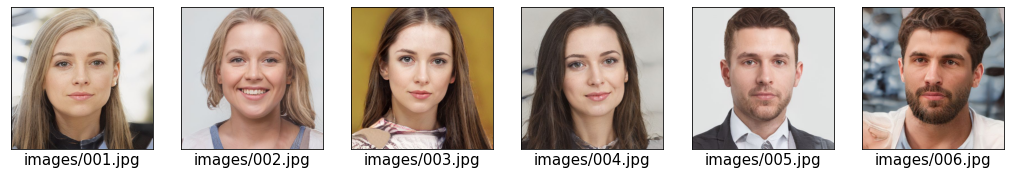

In [4]:
# --- サンプル画像表示 ---
display_pic("images")

100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


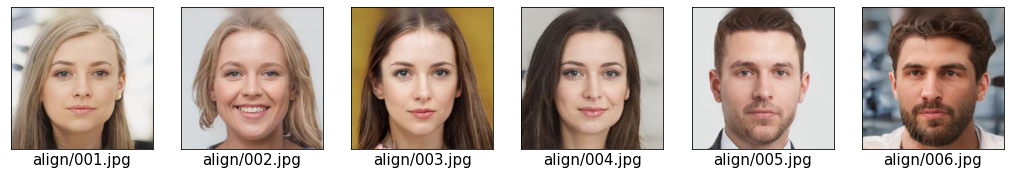

In [5]:
# --- 顔画像の切り出し ---
import os
import shutil

from tqdm import tqdm

if os.path.isdir("align"):
    shutil.rmtree("align")
os.makedirs("align", exist_ok=True)


def run_alignment(image_path):
    import dlib
    from utils.alignment import align_face

    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    return aligned_image


files = sorted(os.listdir("./images"))
for i, file in enumerate(tqdm(files)):
    if file == ".ipynb_checkpoints":
        continue
    input_image = run_alignment("./images/" + file)
    input_image.resize((256, 256))
    input_image.save("./align/" + file)

display_pic("align")

# 潜在変数の推定

100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


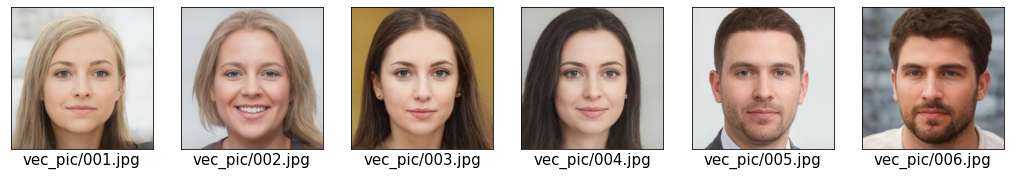

In [6]:
# --- 潜在変数の推定 ---
if os.path.isdir("vec_pic"):
    shutil.rmtree("vec_pic")
os.makedirs("vec_pic", exist_ok=True)

if os.path.isdir("vec"):
    shutil.rmtree("vec")
os.makedirs("vec", exist_ok=True)

img_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

files = sorted(os.listdir("./align"))
for i, file in enumerate(tqdm(files)):
    if file == ".ipynb_checkpoints":
        continue
    input_image = Image.open("./align/" + file)
    transformed_image = img_transforms(input_image)
    with torch.no_grad():
        images, latents = net(
            transformed_image.unsqueeze(0).to("cuda").float(),
            randomize_noise=False,
            return_latents=True,
        )
        result_image, latent = images[0], latents[0]
        tensor2im(result_image).save("./vec_pic/" + file)
        torch.save(latents, "./vec/" + file[:-4] + ".pt")

display_pic("vec_pic")

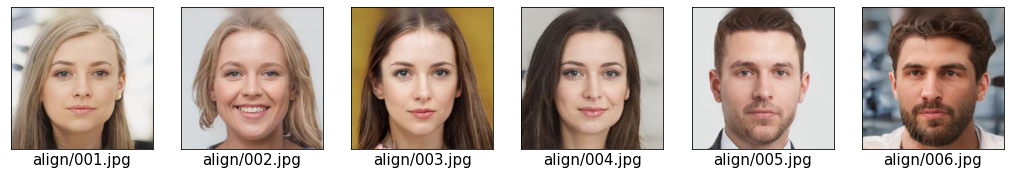

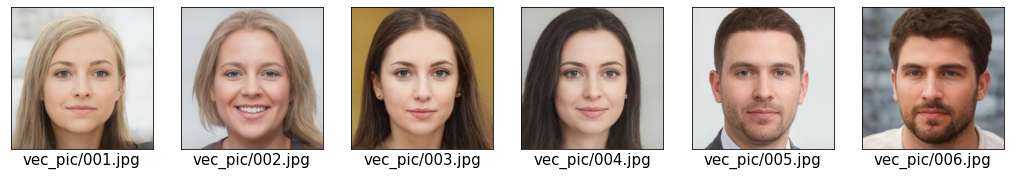

In [7]:
# --- 実写と潜在変数の比較 ---
display_pic("align")
display_pic("vec_pic")

# 潜在変数の編集

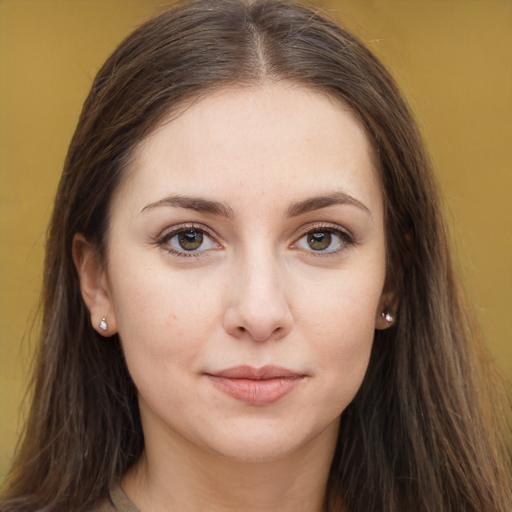

In [8]:
# --- 潜在変数の選択 ---
pt_folder = "vec/"
pt_name = "003.pt"  # @param {type:"string"}
latents = torch.load(pt_folder + pt_name)
w_plus = latents.cpu().detach().numpy()
M.dlatents = M.W2S(w_plus)

M.num_images = 1
M.alpha = [0]
M.manipulate_layers = [0]
codes, out = M.EditOneC(0, M.dlatents)
original = Image.fromarray(out[0, 0]).resize((512, 512))
M.manipulate_layers = None
original

In [9]:
# --- 編集テキスト入力 ---
neutral = "face"  # @param {type:"string"}
target = "smiling face"  # @param {type:"string"}
classnames = [target, neutral]
dt = GetDt(classnames, model)

0.364


(-0.5, 1023.5, 1023.5, -0.5)

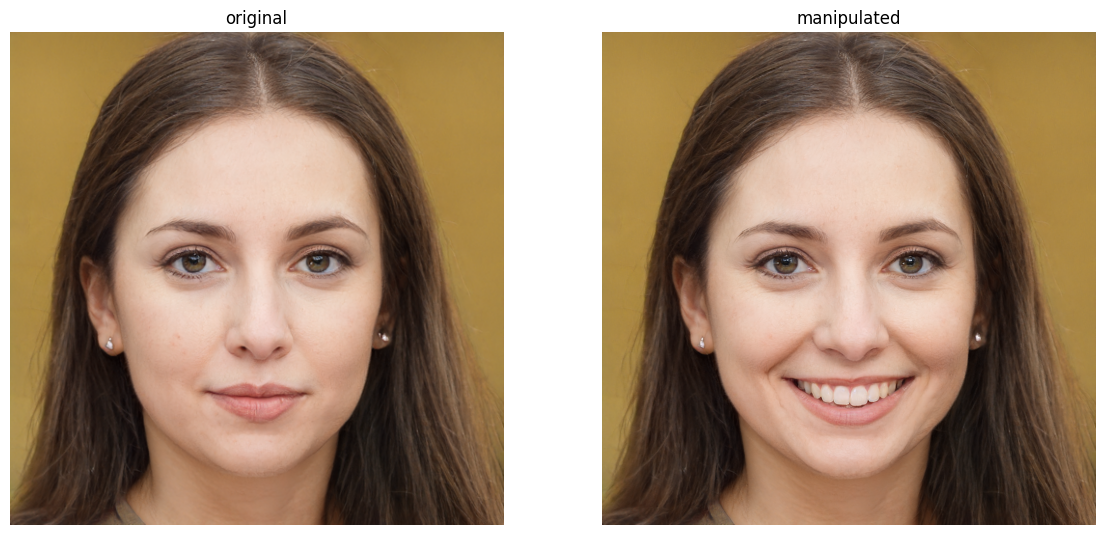

In [10]:
# --- alpha & beta の設定 ---
beta = 0.1  # @param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 2  # @param {type:"slider", min:-10, max:10, step:0.1}
M.alpha = [alpha]
boundary_tmp2, c = GetBoundary(fs3, dt, M, threshold=beta)
codes = M.MSCode(M.dlatents, boundary_tmp2)
out = M.GenerateImg(codes)
generated = Image.fromarray(out[0, 0])  # .resize((512,512))
generated.save("generated.jpg")

plt.figure(figsize=(14, 7), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("original")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(generated)
plt.title("manipulated")
plt.axis("off")